# Demo
Tristan, 2/27/2019

This is a tour of this project intended for live screenshare.  All of this is basically condensed from other jupyter notebooks.  Feel free to ask me to skip over any point, or expand upon others.

## Introductory comments
*Dominion* is a popular card game with many distinct cards.  Each year, the community democratically [ranks the cards](http://wiki.dominionstrategy.com/index.php/List_of_Cards_by_Qvist_Rankings) by power level.

My goal is to construct a metric that partially predicts community rankings.  The metric will help us understand what it means for a card to be "powerful", and also to suggest what cards that might be misranked by the community.

At the beginning of each game, 10 cards are selected to be in the "supply".  If a card is in the "supply", then it is available to be "gained".  One possible metric is the **gain percentage**:

$\mathrm{gain\%}(X) = P(\mathrm{gain}(X)|\mathrm{supply}(X))$

But I define a more complicated metric, which I call the **impact factor**:

$\mathrm{impact}(X) = \sum_Y \Big | P(\mathrm{gain}(Y)|\mathrm{supply}(X)) - P(\mathrm{gain}(Y))\Big|$

To calculate the impact factor, the very first step is to collect data.  I have 140,000 text documents (see "sample log.txt") containing game logs, and I wrote code to parse the logs and summarize the data.  Here, I will simply load the data.

In [51]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

#refresh my modules in case I change anything
if 'analysis_functions' in sys.modules:
    del sys.modules['analysis_functions']
from analysis_functions import *
if 'PCA_plotting' in sys.modules:
    del sys.modules['PCA_plotting']
from PCA_plotting import card_model

## Gain data

In [52]:
#load data
num_games, game_gains, total_gains, card_list, card_dict = init_data()

In [8]:
#There are 217 different cards, each corresponding to a column and row
print(num_games.shape)
print(num_games)

(217, 217)
[[14090   136   690 ...   638   544   656]
 [  136  3124   140 ...   164   114   162]
 [  690   140 13666 ...   650   562   586]
 ...
 [  638   164   650 ... 14082   582   572]
 [  544   114   562 ...   582 12206   520]
 [  656   162   586 ...   572   520 13796]]


In [11]:
#card_list contains the names of each card in order, and card_dict tells you the index of any particular card
print(card_list[0:5])
print(card_dict['Cache'])

['Warehouse', 'Envoy', 'Sea Hag', 'Cache', 'Trade Route']
3


In [53]:
# of course, it might be more readable if num_games were in a pandas DataFrame.
num_games_df = pd.DataFrame(num_games)
num_games_df.index = card_list
num_games_df.columns = card_list
num_games_df.head()

,Warehouse,Envoy,Sea Hag,Cache,Trade Route,Village,Poor House,Stables,Hamlet,Black Market,...,Fishing Village,Mining Village,Mystic,Young Witch,Beggar,Rats,Fool's Gold,Bandit Camp,Butcher,Fairgrounds
Warehouse,14090,136,690,596,672,616,660,606,614,302,...,632,722,612,860,638,686,602,638,544,656
Envoy,136,3124,140,138,148,158,148,146,158,110,...,170,122,134,152,124,154,130,164,114,162
Sea Hag,690,140,13666,638,694,612,644,630,620,252,...,636,672,640,620,598,646,642,650,562,586
Cache,596,138,638,13364,612,582,642,638,576,248,...,644,600,584,604,612,572,638,678,510,622
Trade Route,672,148,694,612,14130,674,616,596,642,296,...,632,548,646,856,668,648,666,606,572,580


*num_games* is the number of games with supply(row) & supply(column)

*game_gains* is the number of gains with supply(row) & gain(column)

## Calculating impact

To calculate the impact factor, we need another piece of information, which is P(supply(X)|supply(Y)).  I hardcoded this matrix (called card_weights) based on the game rules.

In [54]:
card_weights = get_card_weights(card_list,card_dict)

Next is just a bunch of math.

In [55]:
#element-wise division
prc_gains = game_gains / num_games

#Apply weighting. Multiply by card_weights[col], except along the diagonal of the matrix
impact_matrix = prc_gains * card_weights

#Now from each row, subtract the vector from the average game
copper = impact_matrix[card_dict['Copper'],:].copy()
impact_matrix -= copper

#Finally, calculate the impact factor for each card
card_impact = np.sum(abs(impact_matrix),axis = 1)

In [56]:
card_impact[0:10]

array([1.15608658, 0.87637656, 1.75387995, 0.54052764, 0.84347608,
       1.1742532 , 0.66581027, 1.11250804, 1.38297998, 1.67891225])

In [57]:
impact_sorted = sort_metric( card_impact, card_list, card_dict )

In [58]:
impact_sorted.head()

,Card,metric
Rank,,
1,Rebuild,2.973071
2,Mountebank,2.550012
3,Goons,2.459193
4,Cultist,2.425984
5,Ill-Gotten Gains,2.378828


## Evaluating the impact factor
I'm going to skip ahead a bit here, and show some graphs plotting community ("qvist") rankings vs the impact factor.

In [66]:
#load previously saved results
impact = pd.read_csv('impact_rankings.csv')
qvist = pd.read_csv('qvist_rankings.csv')
impact = correct_rankings(impact)
qvist_compare = compare_to_qvist(impact,qvist,'5 cost','2014')

In [67]:
#now we can show the rankings based on impact factor vs community rankings
qvist_compare.head()

,Unnamed: 0,Card,Set,Category,2011,2012,2013,2014,2015,2016,2017,2018,Metric ranking
0,216,Wharf,Seaside,5 cost,3.0,3.0,3.0,3.0,4.0,2.0,1.0,1.0,8.0
1,217,Mountebank,Prosperity,5 cost,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0
2,218,Cultist,Dark Ages,5 cost,NaN,NaN,7.0,4.0,3.0,3.0,4.0,3.0,3.0
3,219,Governor,Promo,5 cost,15.0,6.0,6.0,7.0,5.0,5.0,5.0,4.0,5.0
4,222,Margrave,Hinterlands,5 cost,13.0,12.0,13.0,14.0,14.0,12.0,11.0,7.0,24.0


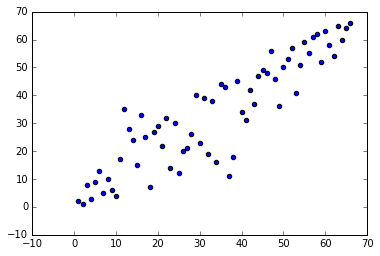

In [68]:
#compare impact rankings (y axis) vs qvist rankings (x axis)
plt.scatter(qvist_compare['2014'],qvist_compare['Metric ranking'])

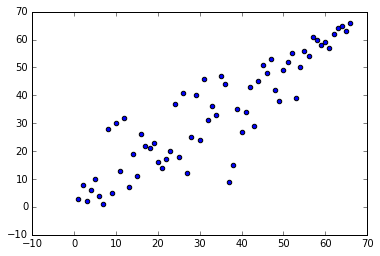

In [61]:
# we can also compare to rankings made with the gain percentage
gain_prc = pd.read_csv('gain_percentage_rankings.csv')
gain_prc = correct_rankings(gain_prc)
gain_compare = compare_to_qvist(gain_prc,qvist,'5 cost','2014')

plt.scatter(gain_compare['2014'],gain_compare['Metric ranking'])

In [62]:
#impact factor is a very slight improvement, as can be determined from the correlation factor
print('Impact score:')
print(score_metric(impact,qvist,'2014'))
print('Gain percentage score:')
print(score_metric(gain_prc,qvist,'2014'))

Impact score:
0.8633299948314384
Gain percentage score:
0.8461272092107612


## PCA analysis
Here I'm skipping even further ahead.  Remember that ~200x200 matrix?  We can take that matrix, alongside its transposition, and give each card ~400 distinct features!  I thought it would be interesting to use this to perform PCA.

I'm glossing over many details, but a simple conceptual understanding is:

- Impact factor ~ length of feature vector ~ card strength
- PCA ~ direction of feature vector ~ card type

In [71]:
#It would take too long to do the PCA analysis, so I'm just loading the results, using an class that I coded for this purpose
model = card_model()

In [72]:
#this sets some graph parameters
model.set_figure_size(10,8)
model.set_label_size(8)
model.set_adjust_text(False)

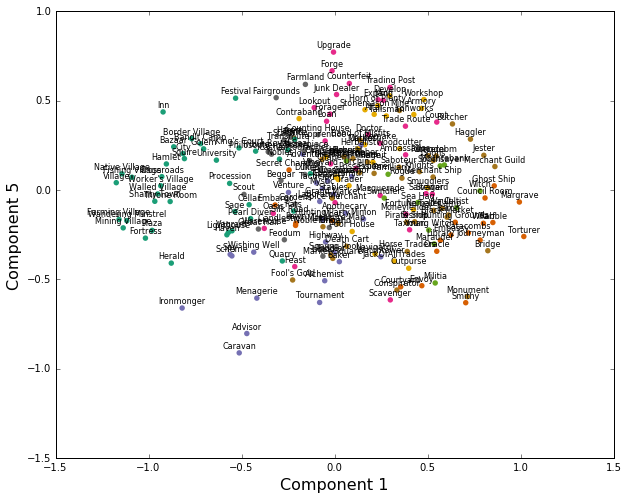

In [73]:
#here, I want to plot the first component, vs the second component
#I use a package to prevent labels from overlapping, but I turned it off to make this run faster!
model.pca_map_color(0,4,axis2_type="card")

Each component is also associated with an 400-dimensional eigenvector. We can understand this as 2 separate 200-dimensional eigenvectors. The first eigenvector I label as "promoted", and the second eigenvector, I label as "loved".

Recall, each feature is associated with a particular card!  So for each card, and each component, I have three values: component X, loved by component X, and promoted by component X.

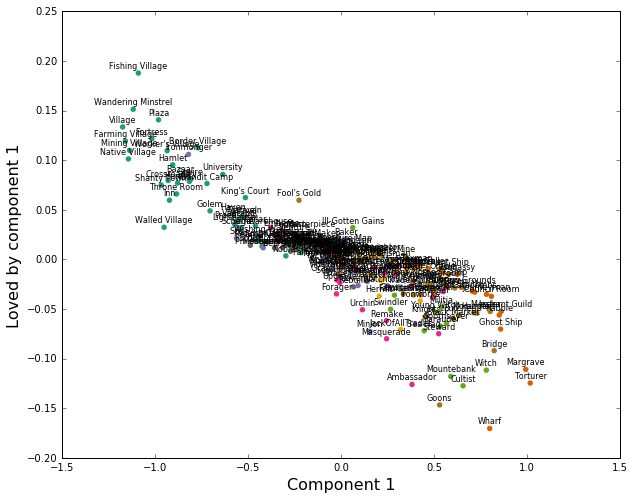

In [79]:
model.pca_map_color(0,0,axis2_type="love")

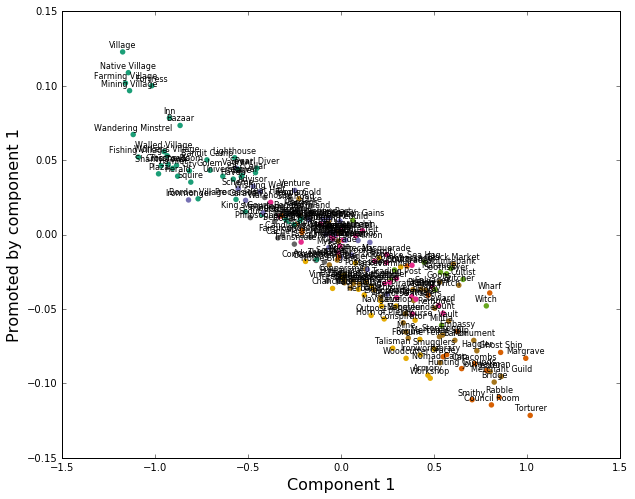

In [49]:
model.pca_map_color(0,0,axis2_type="prom")